In [2]:
from load_data import load_data_from_folder, integrate_ankle_insole, process_camargo_data, normalize_ankle_angle

In [5]:
camargo_ds = process_camargo_data("data/camargo/data/")

Processing camargo: 100%|██████████| 1101/1101 [00:27<00:00, 40.21it/s]


In [10]:
def vote_activity(imu_data):
    activities = [data.activity for data in imu_data]
    activity_counts = {activity: activities.count(activity) for activity in set(activities)}
    # sort by count
    sorted_activities = sorted(activity_counts.items(), key=lambda x: x[1], reverse=True)
    # return the most common activity that is not idle
    for activity, count in sorted_activities:
        if activity != "idle" and '-' not in activity and activity != "stand":
            return activity

In [11]:
class Segment:
    def __init__(self):
        self.start_time = 0
        self.end_time = 0
        self.data = []
        self.activity = None

    def add_data(self, data):
        self.data.append(data)
        if self.start_time == 0:
            self.start_time = data.timestep
        self.end_time = data.timestep

    def detect_activity(self):
        if self.data:
            self.activity = vote_activity(self.data) or "misc"
            if self.end_time-self.start_time > 3:
                self.activity = "misc"
            if "turn" in self.activity:
                self.activity = "walk"
        else:
            self.activity = None

    def interval(self):
        return self.end_time - self.start_time

In [12]:
segments = []
for dataset in camargo_ds:
    current_segment = Segment()
    integrate_ankle_insole(dataset)
    for data in dataset:
        if data.heel_striking:
            if current_segment.data:
                segments.append(current_segment)
            current_segment = Segment()
        current_segment.add_data(data)
    segments.append(current_segment)

In [14]:
# add segments to dataset
from dataset import StrideClassificationDataset
training_ds = StrideClassificationDataset(segments)
print(len(training_ds))

13772


In [15]:
num_classes = len(training_ds.get_label_encoder().classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 6


In [16]:
training_ds.get_label_encoder().classes_

array(['misc', 'rampascent', 'rampdescent', 'stairascent', 'stairdescent',
       'walk'], dtype='<U12')

In [17]:
from collections import Counter
print(Counter(seg.activity for seg in segments))

Counter({'misc': 5636, 'walk': 2670, 'rampdescent': 1995, 'rampascent': 1826, 'stairascent': 825, 'stairdescent': 820})


In [18]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Split dataset into train, validation, and test sets
indices = list(range(len(training_ds)))
labels = [training_ds[i][1] for i in indices]

# 70% train, 15% val, 15% test
train_indices, temp_indices = train_test_split(
    indices,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

val_test_labels = [labels[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    stratify=val_test_labels,
    random_state=42
)

train_subset = Subset(training_ds, train_indices)
val_subset = Subset(training_ds, val_indices)
test_subset = Subset(training_ds, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from models import StrideClassificationCNN

if torch.mps.is_available():
    print("Using MPS (Apple) device")
    device = torch.device('mps')
elif torch.cuda.is_available():
    print("Using CUDA (Nvidia) device")
    device = torch.device('cuda')
else:
    print("Using CPU device")
    device = torch.device('cpu')
model = StrideClassificationCNN(input_channels=7, num_classes=len(training_ds.get_label_encoder().classes_)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 1, Loss: 0.3911, Val Acc: 0.9351
Epoch 2, Loss: 0.1802, Val Acc: 0.9758
Epoch 3, Loss: 0.1153, Val Acc: 0.9753
Epoch 4, Loss: 0.1170, Val Acc: 0.9719
Epoch 5, Loss: 0.1005, Val Acc: 0.9763
Epoch 6, Loss: 0.0854, Val Acc: 0.9792
Epoch 7, Loss: 0.0681, Val Acc: 0.9898
Epoch 8, Loss: 0.0713, Val Acc: 0.9811
Epoch 9, Loss: 0.0517, Val Acc: 0.9811
Epoch 10, Loss: 0.0586, Val Acc: 0.9826
Epoch 11, Loss: 0.0531, Val Acc: 0.9864
Epoch 12, Loss: 0.0520, Val Acc: 0.9821
Epoch 13, Loss: 0.0565, Val Acc: 0.9739
Epoch 14, Loss: 0.0432, Val Acc: 0.9874
Epoch 15, Loss: 0.0400, Val Acc: 0.9913
Epoch 16, Loss: 0.0476, Val Acc: 0.9869
Epoch 17, Loss: 0.0329, Val Acc: 0.9826
Epoch 18, Loss: 0.0307, Val Acc: 0.9845
Epoch 19, Loss: 0.0334, Val Acc: 0.9855
Epoch 20, Loss: 0.0376, Val Acc: 0.9714
Epoch 21, Loss: 0.0446, Val Acc: 0.9840
Epoch 22, Loss: 0.0294, Val Acc: 0.9908
Epoch 23, Loss: 0.0225, Val Acc: 0.9855
Epoch 24, Loss: 0.0386, Val Acc: 0.9898
Epoch 25, Loss: 0.0291, Val Acc: 0.9918
Epoch 26,

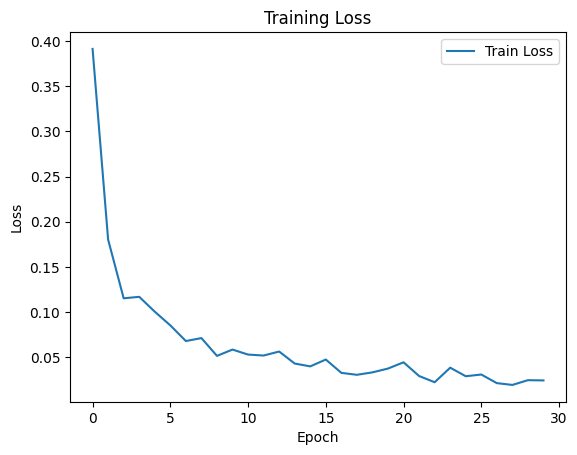

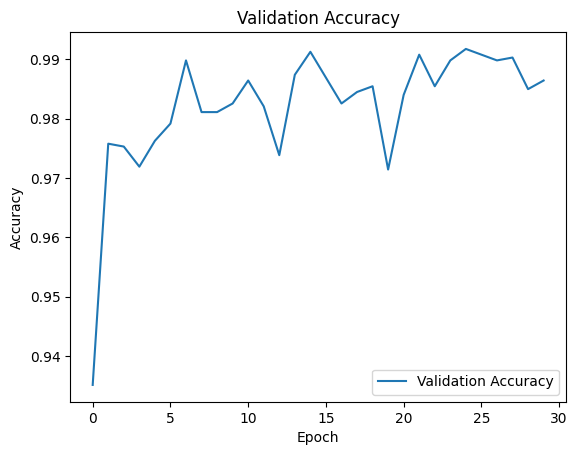

In [22]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []

for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Evaluate on validation set
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu()
            val_preds.extend(preds.numpy())
            val_labels.extend(y_batch.numpy())
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

# Plot training loss
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure()
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [23]:
# save model
torch.save(model.state_dict(), "stride_classification_model.pth")

In [24]:
# load a previous model
# model = StrideClassificationCNN(input_channels=7, num_classes=len(training_ds.get_label_encoder().classes_)).to(device)
# model.load_state_dict(torch.load("stride_classification_model.pth"))

In [26]:
# Final evaluation on test set
from sklearn.metrics import classification_report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

# Decode and print classification report
label_encoder = training_ds.get_label_encoder()
labels = list(range(len(label_encoder.classes_)))
print("Test Classification Report:")
print(classification_report(all_labels, all_preds, labels=labels, target_names=label_encoder.classes_))

Test Classification Report:
              precision    recall  f1-score   support

        misc       0.98      0.99      0.99       846
  rampascent       0.99      0.99      0.99       274
 rampdescent       1.00      0.96      0.98       299
 stairascent       1.00      0.99      1.00       124
stairdescent       1.00      1.00      1.00       123
        walk       0.98      0.98      0.98       400

    accuracy                           0.99      2066
   macro avg       0.99      0.99      0.99      2066
weighted avg       0.99      0.99      0.99      2066



In [29]:
michael_walk_data, insole_data, _ = load_data_from_folder("data/04_03_walk/", [159], [202], 0, 30.5731)
integrate_ankle_insole(michael_walk_data, insole_data)
michael_walk_data = normalize_ankle_angle(michael_walk_data)
for data in michael_walk_data:
    data.activity = "walk"

michael_downramp_data, insole_data, _ = load_data_from_folder("data/01_16_ramp/", [10,43], [20,55], 0, -0.8789)
integrate_ankle_insole(michael_downramp_data, insole_data)
michael_downramp_data = normalize_ankle_angle(michael_downramp_data)
for data in michael_downramp_data:
    data.activity = "rampdescent"

michael_upramp_data, insole_data, _ = load_data_from_folder("data/01_16_ramp/", [23,62], [34,71], 0, -0.8789)
integrate_ankle_insole(michael_upramp_data, insole_data)
michael_upramp_data = normalize_ankle_angle(michael_upramp_data)
for data in michael_upramp_data:
    data.activity = "rampascent"

michael_downstairs_data, insole_data, _ = load_data_from_folder("data/01_22_downstairs/", 20, 1e9, 0, 0.3675)
integrate_ankle_insole(michael_downstairs_data, insole_data)
michael_downstairs_data = normalize_ankle_angle(michael_downstairs_data)
for data in michael_downstairs_data:
    data.activity = "stairdescent"

michael_upstairs_data, insole_data, _ = load_data_from_folder("data/01_22_upstairs/", 0, 1e9, 0, 2.5461)
integrate_ankle_insole(michael_upstairs_data, insole_data)
michael_upstairs_data = normalize_ankle_angle(michael_upstairs_data)
for data in michael_upstairs_data:
    data.activity = "stairascent"

mohsen_walk_data, insole_data, _ = load_data_from_folder("data/04_14_walk_stair_vending/", 0, 1e9, 0, -60.3619)
integrate_ankle_insole(mohsen_walk_data, insole_data)
mohsen_walk_data = normalize_ankle_angle(mohsen_walk_data)
for data in mohsen_walk_data:
    data.activity = "walk"

mohsen_walk_data2, insole_data, _ = load_data_from_folder("data/04_14_walk_vending_stair/", 0, 1e9, 0, -6.8690)
integrate_ankle_insole(mohsen_walk_data2, insole_data)
mohsen_walk_data2 = normalize_ankle_angle(mohsen_walk_data2)
for data in mohsen_walk_data2:
    data.activity = "walk"

mohsen_walk_data3, insole_data, _ = load_data_from_folder("data/04_14_outdoor_fitz_walk/", 0, 1e9, 0, -7.9118)
integrate_ankle_insole(mohsen_walk_data3, insole_data)
mohsen_walk_data3 = normalize_ankle_angle(mohsen_walk_data3)
for data in mohsen_walk_data3:
    data.activity = "walk"

mohsen_walk_data4, insole_data, _ = load_data_from_folder("data/04_14_walk_fitz_bond/", 0, 1e9, 0, -35.8358)
integrate_ankle_insole(mohsen_walk_data4, insole_data)
mohsen_walk_data4 = normalize_ankle_angle(mohsen_walk_data4)
for data in mohsen_walk_data4:
    data.activity = "walk"

mohsen_walk_data5, insole_data, _ = load_data_from_folder("data/04_14_walk_main_fitz/", 0, 1e9, 0, 3.4172)
integrate_ankle_insole(mohsen_walk_data5, insole_data)
mohsen_walk_data5 = normalize_ankle_angle(mohsen_walk_data5)
for data in mohsen_walk_data5:
    data.activity = "walk"

mohsen_downramp_data1, insole_data, _ = load_data_from_folder("data/04_14_downramp_bond_x2/", 0, 1e9, 0, -22.4661)
integrate_ankle_insole(mohsen_downramp_data1, insole_data)
mohsen_downramp_data1 = normalize_ankle_angle(mohsen_downramp_data1)
for data in mohsen_downramp_data1:
    data.activity = "rampdescent"

mohsen_downramp_data2, insole_data, _ = load_data_from_folder("data/04_14_downramp_lake/", 0, 1e9, 0, -7.1484)
integrate_ankle_insole(mohsen_downramp_data2, insole_data)
mohsen_downramp_data2 = normalize_ankle_angle(mohsen_downramp_data2)
for data in mohsen_downramp_data2:
    data.activity = "rampdescent"

mohsen_downramp_data3, insole_data, _ = load_data_from_folder("data/04_14_downramp_columba_hall/", 0, 1e9, 0, 2.3692)
integrate_ankle_insole(mohsen_downramp_data3, insole_data)
mohsen_downramp_data3 = normalize_ankle_angle(mohsen_downramp_data3)
for data in mohsen_downramp_data3:
    data.activity = "rampdescent"

mohsen_upramp_data1, insole_data, _ = load_data_from_folder("data/04_14_upramp_bond_x2/", 0, 1e9, 0, 1.4235)
integrate_ankle_insole(mohsen_upramp_data1, insole_data)
mohsen_upramp_data1 = normalize_ankle_angle(mohsen_upramp_data1)
for data in mohsen_upramp_data1:
    data.activity = "rampascent"

mohsen_upramp_data2, insole_data, _ = load_data_from_folder("data/04_14_upramp_lake/", 0, 1e9, 0, 2.7880)
integrate_ankle_insole(mohsen_upramp_data2, insole_data)
mohsen_upramp_data2 = normalize_ankle_angle(mohsen_upramp_data2)
for data in mohsen_upramp_data2:
    data.activity = "rampascent"

mohsen_upramp_data3, insole_data, _ = load_data_from_folder("data/04_14_upramp_columba_hall/", 0, 1e9, 0, -7.3961)
integrate_ankle_insole(mohsen_upramp_data3, insole_data)
mohsen_upramp_data3 = normalize_ankle_angle(mohsen_upramp_data3)
for data in mohsen_upramp_data3:
    data.activity = "rampascent"

mohsen_upstairs_data1, insole_data, _ = load_data_from_folder("data/04_14_upstairs_leftfoot_main/", 0, 1e9, 0, -13.6291)
integrate_ankle_insole(mohsen_upstairs_data1, insole_data)
mohsen_upstairs_data1 = normalize_ankle_angle(mohsen_upstairs_data1)
for data in mohsen_upstairs_data1:
    data.activity = "stairascent"

mohsen_upstairs_data2, insole_data, _ = load_data_from_folder("data/04_14_upstairs_rightfoot_main/", 0, 1e9, 0, -11.0419)
integrate_ankle_insole(mohsen_upstairs_data2, insole_data)
mohsen_upstairs_data2 = normalize_ankle_angle(mohsen_upstairs_data2)
for data in mohsen_upstairs_data2:
    data.activity = "stairascent"

mohsen_downstairs_data1, insole_data, _ = load_data_from_folder("data/04_14_downstairs_leftfoot_main/", 0, 1e9, 0, 9.3960)
integrate_ankle_insole(mohsen_downstairs_data1, insole_data)
mohsen_downstairs_data1 = normalize_ankle_angle(mohsen_downstairs_data1)
for data in mohsen_downstairs_data1:
    data.activity = "stairdescent"

mohsen_downstairs_data2, insole_data, _ = load_data_from_folder("data/04_14_downstairs_rightfoot_main/", 0, 1e9, 0, 5.0417)
integrate_ankle_insole(mohsen_downstairs_data2, insole_data)
mohsen_downstairs_data2 = normalize_ankle_angle(mohsen_downstairs_data2)
for data in mohsen_downstairs_data2:
    data.activity = "stairdescent"

michael_data = michael_walk_data + michael_downramp_data + michael_upramp_data + michael_downstairs_data + michael_upstairs_data
mohsen_data = mohsen_walk_data + mohsen_walk_data2 + mohsen_walk_data3 + mohsen_walk_data4 + mohsen_walk_data5 + \
    mohsen_downramp_data1 + mohsen_downramp_data2 + mohsen_downramp_data3 + \
    mohsen_upramp_data1 + mohsen_upramp_data2 + mohsen_upramp_data3 + \
    mohsen_upstairs_data1 + mohsen_upstairs_data2 + \
    mohsen_downstairs_data1 + mohsen_downstairs_data2

In [30]:
segments = []
current_segment = Segment()
for data in mohsen_data:
    if data.heel_striking:
        if current_segment.data:
            segments.append(current_segment)
        current_segment = Segment()
    current_segment.add_data(data)
segments.append(current_segment)
training_ds = StrideClassificationDataset(segments)

In [31]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Split dataset into train, validation, and test sets
indices = list(range(len(training_ds)))
labels = [training_ds[i][1] for i in indices]

# 70% train, 30%
train_indices, test_indices = train_test_split(
    indices,
    test_size=0.7,
    stratify=labels,
    random_state=42
)

train_subset = Subset(training_ds, train_indices)
test_subset = Subset(training_ds, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Epoch 1, Loss: 3.6736
Epoch 2, Loss: 1.0868
Epoch 3, Loss: 0.9196
Epoch 4, Loss: 0.8621
Epoch 5, Loss: 0.7579
Epoch 6, Loss: 0.7188
Epoch 7, Loss: 0.6923
Epoch 8, Loss: 0.6774
Epoch 9, Loss: 0.5949
Epoch 10, Loss: 0.5959
Epoch 11, Loss: 0.6806
Epoch 12, Loss: 0.5797
Epoch 13, Loss: 0.5886
Epoch 14, Loss: 0.5549
Epoch 15, Loss: 0.6038


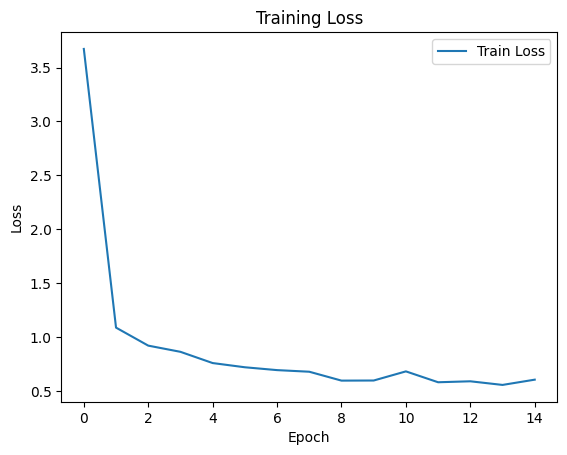

In [32]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []

for epoch in range(15):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}")

# Plot training loss
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [33]:
# Final evaluation on test set
from sklearn.metrics import classification_report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y_batch.numpy())

# Decode and print classification report
label_encoder = training_ds.get_label_encoder()
labels = list(range(len(label_encoder.classes_)))
print("Test Classification Report:")
print(classification_report(all_labels, all_preds, labels=labels, target_names=label_encoder.classes_))

Test Classification Report:
              precision    recall  f1-score   support

        misc       0.47      0.41      0.44        22
  rampascent       0.54      0.47      0.50       130
 rampdescent       0.57      0.30      0.40       125
 stairascent       0.53      0.63      0.58        30
stairdescent       0.72      0.58      0.64        31
        walk       0.81      0.92      0.86       577

    accuracy                           0.74       915
   macro avg       0.61      0.55      0.57       915
weighted avg       0.72      0.74      0.72       915

